In [1]:
import torch # import pytorch
import torch.nn as nn # import the neural network class from pytorch
import torch.optim as optim# import optim class the loads the optimizer that trains the NN
import torch.utils.data# import torch.utils.data so that we can call the dataloader funtion that divides,shuffles the data
import torchvision.transforms as transforms# import transforms from torch vision so that we can apply a group of processes on the images before they are loaded into the dataset
import torch.nn.functional as F#import functional that includes all activation functions
from torch.autograd import Variable# import variable so that we separate each tensor to data,grad so that later we can detach them from each others
import torchvision.utils as vutils# import vutils so that we can save the images
import torchvision#import torchvision


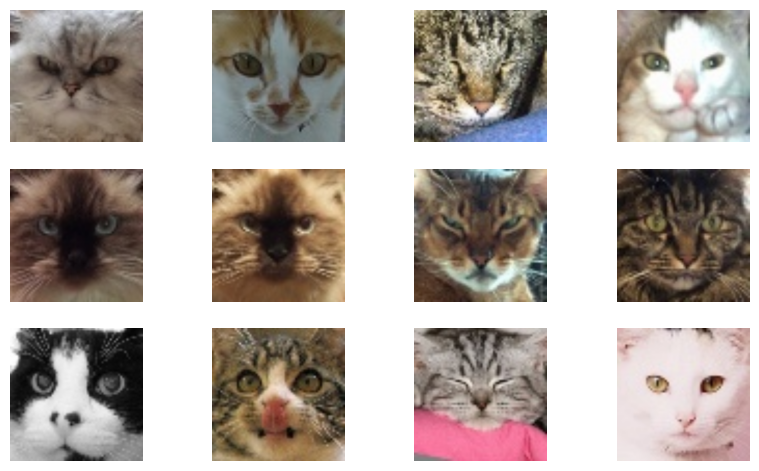

In [24]:
import matplotlib.pyplot as plt
import glob
import cv2
imgs=glob.glob('data\cats\*.jpg')
fig = plt.figure(figsize=(10, 10))
for j,i in enumerate(imgs[:12]):
    img = cv2.imread(i)
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig.add_subplot(5, 4, j+1,)
    # showing image
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
batchSize = 32 # We set the size of the batch.
imageSize = 64 # We set the size of the generated images (64x64).
device=torch.device('cuda:0')# naem device variable to GPU 
# Creating the transformations resisze-->transform image to tensor-->normalize by thesese means
transform = transforms.Compose([transforms.Resize((imageSize,imageSize)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # We create a list of transformations (scaling, tensor conversion, normalization) to apply to the input images.

# Loading the dataset
dataset = torchvision.datasets.ImageFolder(root = 'data', transform = transform) # We download the training set in the ./data folder and we apply the previous transformations on each image.
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2) # We use dataLoader to get the images of the training set batch by batch.


def weights_init_normal(m):#weight initialization function for diffrent layes
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:# for convolution
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:#for batchnorm
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

    

In [ ]:
class G(nn.Module):
    def __init__(self):
        super(G,self).__init__()
        # the order of parameters are writen in the comments beside each line
        self.conv1=nn.ConvTranspose2d(100,512,4,1,0,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch1=nn.BatchNorm2d(512)
        self.conv2=nn.ConvTranspose2d(512,256,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch2=nn.BatchNorm2d(256)
        self.conv3=nn.ConvTranspose2d(256,128,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch3=nn.BatchNorm2d(128)
        self.conv4=nn.ConvTranspose2d(128,64,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch4=nn.BatchNorm2d(64)
        self.conv5=nn.ConvTranspose2d(64,3,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
    def forward(self,x):
        x=F.relu(self.batch1(self.conv1(x)),inplace=True)#means that it will modify the input directly, without allocating any additional output.
        #It can sometimes slightly decrease the memory usage
        x=F.relu(self.batch2(self.conv2(x)),inplace=True)
        x=F.dropout2d(x,0.25)
        x=F.relu(self.batch3(self.conv3(x)),inplace=True)
        x=F.relu(self.batch4(self.conv4(x)),inplace=True)
        x=F.tanh(self.conv5(x))
        return x
class D(nn.Module):
    def __init__(self):
        super(D,self).__init__()
        self.conv1=nn.Conv2d(3,64,4,2,1,bias=False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
        self.conv2=nn.Conv2d(64,128,4,2,1,bias=False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
        self.batch2=nn.BatchNorm2d(128)#input
        self.conv3=nn.Conv2d(128,256,4,2,1,bias=False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
        self.batch3=nn.BatchNorm2d(256)
        self.conv4=nn.Conv2d(256,512,4,2,1,bias=False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
        self.batch4=nn.BatchNorm2d(512)
        self.conv5=nn.Conv2d(512, 1, 4, 1, 0, bias = False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
    def forward(self,x):
        x=F.leaky_relu(self.conv1(x),negative_slope=0.2,inplace=True)
        x=F.leaky_relu(self.batch2(self.conv2(x)),negative_slope=0.2,inplace=True)
        x=F.dropout2d(x,0.3)
        x=F.leaky_relu(self.batch3(self.conv3(x)),negative_slope=0.2,inplace=True)
        x=F.leaky_relu(self.batch4(self.conv4(x)),negative_slope=0.2,inplace=True)
        x=F.sigmoid(self.conv5(x))
        return x.view(-1)

losses_g=[]#empty list to store genrator loss values so we can visualize them later
losses_d=[]#empty list to store descriminator loss values so we can visualize them later
gen=G().to(device)# set device of the NN to GPU
desc=D().to(device)# set device of the NN to GPU
gen.apply(weights_init_normal)
desc.apply(weights_init_normal)


In [ ]:
def train(epochs,desc,gen,dataloader):
    optimizer_d=optim.Adam(desc.parameters(), lr = 0.0002, betas = (0.5, 0.999))# baetas are coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    optimizer_g=optim.Adam(gen.parameters(), lr = 0.0002, betas = (0.5, 0.999))# baetas are coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    loss_fn=nn.BCELoss()# set loss function to binary cross entropy
    prev=100# any large number
    for i in range(epochs):
        for j,data in enumerate(dataloader):
            # train desc on real
            optimizer_d.zero_grad()# set gradient to zero so that each iteration isnt affected with the ones before it
            real,_=data# get real images data
            real=real.view(-1,3,64,64)# resize them to be (batch_size,3,64,64)
            real=Variable(real).to(device)# set data device to GPU
            target=Variable(torch.ones(real.size()[0])).to(device)# creat a tensor of ones (real output)
            output=desc(real)# get descriminator predictions on real data (supposed to be 1)
            err_d_real=loss_fn(output,target)# get loss on real data 
          
            #train desc on fake
            
            target=Variable(torch.zeros(real.size()[0])).to(device)# tensor of zeors
            noise=Variable(torch.randn((real.size()[0],100,1,1))).to(device)# create random noise tensor
            fake=gen(noise)# genrate fake image
            output=desc(fake)# get prediction of descriminator on fake images supposed to be 0
            err_d_fake=loss_fn(output,target)# get loss
            #gradient descent
            err_d=err_d_fake+err_d_real# add both losses of decriminator
            err_d.backward()# calculate the gradient descent
            optimizer_d.step()#update weights
            #train gen
            optimizer_g.zero_grad()# set genrator gradient to zero so it doesnt get affected by previous itterations
            target=Variable(torch.ones(real.size()[0])).to(device)#tensor of ones
            noise=Variable(torch.randn((real.size()[0],100,1,1))).to(device)# create random noise tensor
            fake=gen(noise)# genrate fake images
            output=desc(fake)# get prediction of descriminator on fake images supposed to be 1 
            err_g=loss_fn(output,target)# calculate loss
            err_g.backward()# calculate gradient descent
            optimizer_g.step()#update weight
            if j%10==0:
                print('-',end=' ')# print "-" each 10 itterations
        print('>\n')# print ">" at the end of each epoch
        print(f' err_d={err_d.data}  err_g={err_g.data}')
        losses_d.append(err_d.data)# append the loss value of descriminator so we can visualize it
        losses_g.append(err_g.data)# append the loss value of genrator so we can visualize it
        torch.save(gen,f'models//genrator_new_{i}.pt')# save models at a file named models
        torch.save(desc,f'models//discriminator_new_{i}.pt')
        prev=err_g
        vutils.save_image(real, f'real_1.jpg', normalize = True) # We save the real images of the minibatch.
        fake = gen(noise) # We get our fake generated images.
        vutils.save_image(fake.data, f'output//fake_1_{i}.jpg', normalize = True) # We also save the fake generated images of the minibatch.

In [2]:
train(30,desc,gen,dataloader)

C:\Users\abdel\anaconda3\envs\tfgpu\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\abdel\anaconda3\envs\tfgpu\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=2.2051141262054443  err_g=2.9088971614837646
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=1.9684232473373413  err_g=2.9202442169189453
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=0.022667791694402695  err_g=3.7568001747131348
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=0.6460293531417847  err_g=3.245957374572754
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=0.053717367351055145  err_g=1.9514634609222412
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=0.3854128122329712  err_g=2.190850019454956
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [10]:
losses_desc=[]
for i in losses_d:
    losses_desc.append(float(i))# transform values to float
losses_gen=[]
for i in losses_g:
    losses_gen.append(float(i))


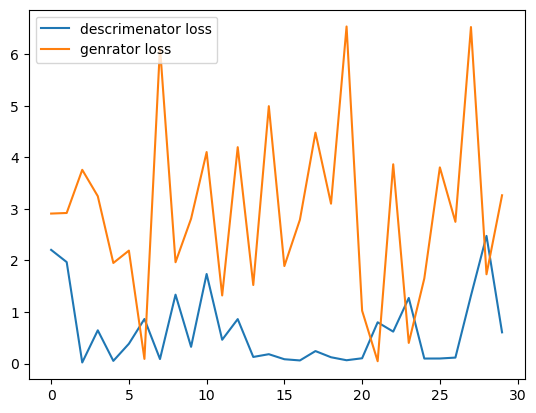

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses_desc,label='descrimenator loss')#plot the losses
plt.plot(losses_gen,label='genrator loss')
plt.legend()
plt.show()

In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
device=torch.device('cuda:0')

class G(nn.Module):
    def __init__(self):
        super(G,self).__init__()
        self.conv1=nn.ConvTranspose2d(100,512,4,1,0,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch1=nn.BatchNorm2d(512)
        self.conv2=nn.ConvTranspose2d(512,256,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch2=nn.BatchNorm2d(256)
        self.conv3=nn.ConvTranspose2d(256,128,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch3=nn.BatchNorm2d(128)
        self.conv4=nn.ConvTranspose2d(128,64,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch4=nn.BatchNorm2d(64)
        self.conv5=nn.ConvTranspose2d(64,3,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
    def forward(self,x):
        x=F.relu(self.batch1(self.conv1(x)),inplace=True)#means that it will modify the input directly, without allocating any additional output.
        #It can sometimes slightly decrease the memory usage
        x=F.relu(self.batch2(self.conv2(x)),inplace=True)
        x=F.dropout2d(x,0.25)
        x=F.relu(self.batch3(self.conv3(x)),inplace=True)
        x=F.relu(self.batch4(self.conv4(x)),inplace=True)
        x=F.tanh(self.conv5(x))
        return x
class D(nn.Module):
    def __init__(self):
        super(D,self).__init__()
        self.conv1=nn.Conv2d(3,64,4,2,1,bias=False)
        self.conv2=nn.Conv2d(64,128,4,2,1,bias=False)
        self.batch2=nn.BatchNorm2d(128)
        self.conv3=nn.Conv2d(128,256,4,2,1,bias=False)
        self.batch3=nn.BatchNorm2d(256)
        self.conv4=nn.Conv2d(256,512,4,2,1,bias=False)
        self.batch4=nn.BatchNorm2d(512)
        self.conv5=nn.Conv2d(512, 1, 4, 1, 0, bias = False)
    def forward(self,x):
        x=F.leaky_relu(self.conv1(x),negative_slope=0.2,inplace=True)
        x=F.leaky_relu(self.batch2(self.conv2(x)),negative_slope=0.2,inplace=True)
        x=F.dropout2d(x,0.3)
        x=F.leaky_relu(self.batch3(self.conv3(x)),negative_slope=0.2,inplace=True)
        x=F.leaky_relu(self.batch4(self.conv4(x)),negative_slope=0.2,inplace=True)
        x=F.sigmoid(self.conv5(x))
        return x.view(-1)
gen=torch.load('models//genrator_new_29.pt')




def genrate(filename="output.jpg"):
    noise=torch.randn((1,100,1,1)).to(device)
    fake=gen(noise)
    vutils.save_image(fake.data, filename, normalize = True) # We also save the fake generated images of the minibatch.
    img=plt.imread(filename)
    plt.imshow(img)
    plt.show()

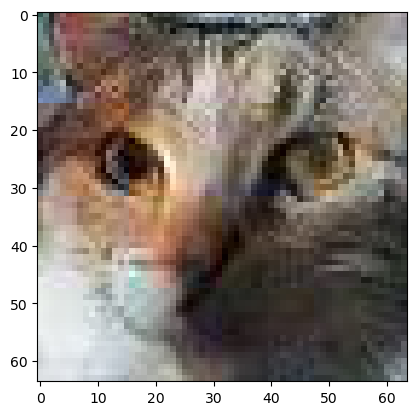

In [7]:
genrate()

## genrate any number of cats

In [6]:
n=int(input("enter number of images you want to genrate"))
for i in range(n):
    genrate(f'output_imgs//output_{i}.jpg')
    

enter number of images you want to genrate 300


C:\Users\abdel\anaconda3\envs\tfgpu\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
